## **Transformer Code Practice**

* BLEU score
* Postional Encoding
* Scaeld Dot-Product Attention
* Multi-Head Attention
* <font color="red">Feed Forward...</font>

참고 : 
* https://paul-hyun.github.io/transformer-01/ 
* https://github.com/paul-hyun/transformer-evolution 

### **사전 작업**

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 4.0 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 라이브러리 import
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import sentencepiece as spm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# 파일 경로 설정
data_dir = "/content/drive/MyDrive/Colab Notebooks/Transformer"

## **BLEU Score**

참고 :
* https://jrc-park.tistory.com/273
* https://wikidocs.net/31695
* https://donghwa-kim.github.io/BLEU.html


Attention is All You Need 에서는 BLEU score를 기준으로 SOTA model을 갱신했다고 하는데, <br>
여기서 BLEU Score가 무엇인지 파악해도록 하겠습니다. <br>

Generated Sentece를 평가하는 방식 중 하나인 BLEU(Biingual Evaluation Understudy)는 자연어 처리 모델의 성능이 <br> 얼마나 뛰어난가를 측정하기 위해 사용되는 대표적인 방법 중 하나입니다.



In [ ]:
import nltk.translate.bleu_score as bleu

candidate = 'It is a guide to action which ensures that the military always obeys the commands of the party'
references = [
    'It is a guide to action that ensures that the military will forever heed Party commands',
    'It is the guiding principle which guarantees the military forces always being under the command of the Party',
    'It is the practical guide for the army always to heed the directions of the party'
]

print('BLEU Score :',bleu.sentence_bleu(list(map(lambda ref: ref.split(), references)),candidate.split(), weights=(1, 0, 0, 0)))
print('BLEU Score :',bleu.sentence_bleu(list(map(lambda ref: ref.split(), references)),candidate.split(), weights=(0.5, 0.5, 0, 0)))
print('BLEU Score :',bleu.sentence_bleu(list(map(lambda ref: ref.split(), references)),candidate.split(), weights=(0.25, 0.25, 0.25, 0.25)))

BLEU Score : 0.9444444444444444
BLEU Score : 0.7453559924999299
BLEU Score : 0.5045666840058485


## **Postional Encoding**


<a href='https://ifh.cc/v-m7sL4m' target='_blank'><img src='https://ifh.cc/g/m7sL4m.jpg' border='0' width="50%"></a>

<font size="4">$\quad PE_{(pos, 2i)} = sin(pos/10000^{2i/d_{model}})$ </font>

<font size="4">$PE_{(pos, 2i+1)} = cos(pos/10000^{2i/d_{model}})$ </font>


In [ ]:
# vocab loading (미리 만들어놓은 vocab 업로드)
vocab_file = f"{data_dir}/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

# 입력 texts
lines = [
  "겨울은 추워요.",
  "감기 조심하세요."
]
    
# text를 tensor로 변환
inputs = []
for idx, line in enumerate(lines):
    pieces = vocab.encode_as_pieces(line)
    ids = vocab.encode_as_ids(line)
    inputs.append(torch.tensor(ids))
    print(f'{idx}번째 문장')
    print(pieces)
    print(ids, '\n')

# 입력 길이가 다르므로 입력 최대 길이에 맟춰 padding(0)을 추가 해 줌
inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
# shape
print(inputs.size())
# 값
print(inputs)

0번째 문장
['▁겨울', '은', '▁추', '워', '요', '.']
[3091, 3604, 206, 3958, 3760, 3590] 

1번째 문장
['▁감', '기', '▁조', '심', '하', '세', '요', '.']
[212, 3605, 53, 3832, 3596, 3682, 3760, 3590] 

torch.Size([2, 8])
tensor([[3091, 3604,  206, 3958, 3760, 3590,    0,    0],
        [ 212, 3605,   53, 3832, 3596, 3682, 3760, 3590]])


**-- Input Embedding**

embedding은 입력 토큰을 vector 형태로 변환합니다. <br>
본 논문에서는 d = 512만큼 설정했지만 여기서는 d = 128만큼 설정하겠습니다. <br>

`input_embs.size()` 출력값이 2, 8, 128 만큼 나왔는데, <br>
'2문장, 8단어(최대 단어 개수), 128 차원'이라는 뜻입니다.

In [ ]:
n_vocab = len(vocab) # vocab count
d_hidn = 128 # hidden size
nn_emb = nn.Embedding(n_vocab, d_hidn) # embedding 객체

input_embs = nn_emb(inputs) # input embedding
print(input_embs.size())
print(input_embs)

torch.Size([2, 8, 128])
tensor([[[-0.1421,  0.6306, -0.7490,  ...,  1.3064, -0.8705, -0.2447],
         [ 0.3673,  0.6761, -0.5105,  ..., -0.2747, -0.4493, -0.7103],
         [-1.7454,  0.6743, -1.6177,  ..., -0.6088, -0.6438, -0.2145],
         ...,
         [-1.2813,  0.3444, -0.5184,  ...,  0.8889, -1.0588,  0.4654],
         [-1.5482,  0.0280,  0.8931,  ..., -0.5704,  2.4077,  1.0299],
         [-1.5482,  0.0280,  0.8931,  ..., -0.5704,  2.4077,  1.0299]],

        [[ 2.2807, -0.1671, -0.4197,  ..., -0.8450, -0.2379,  0.1185],
         [ 0.2546,  0.8912,  0.0116,  ...,  0.6089,  0.4495,  0.6470],
         [-0.2236,  0.0989,  2.1149,  ..., -0.2318, -2.0038, -0.3465],
         ...,
         [-0.4514, -1.1650,  2.3831,  ..., -1.3980,  0.9869,  1.4279],
         [-0.8078,  0.8627,  0.9116,  ...,  0.4185, -0.2246,  2.0235],
         [-1.2813,  0.3444, -0.5184,  ...,  0.8889, -1.0588,  0.4654]]],
       grad_fn=<EmbeddingBackward0>)


**-- Positional Encoding**

Position encoding 값을 구하기 위한 함수는 다음과 같습니다.

1. 각 position 별로 angle 값을 구합니다.
2. 구해진 angle 중 짝수 index는 **sin** 값을,
2. 구해진 angle 중 홀수 index는 **cos** 값을 구합니다.

In [ ]:
""" sinusoid position embedding """
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def get_position_angle_vec(position):
            return [position / np.power(10000, 2 * (hid_j // 2) / d_hidn) for hid_j in range(d_hidn)]

    sinusoid_table = np.array([get_position_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i -> 짝수이면 sine
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1 -> 홀수이면 cosine

    return sinusoid_table


(64, 128)


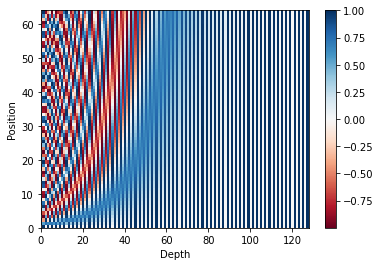

In [ ]:
n_seq = 64
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)

print (pos_encoding.shape) # 크기 출력
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_hidn))
plt.ylabel('Position')
plt.colorbar()
plt.show()

위에서 구한 결과를 그래프로 출력하면 각 position 별로 다른 값을 갖는 것을 확인할 수 있습니다. <br>
(사실 위 그래프를 보고서는 저도 잘 모르겠습니다...)

아래 절차로 position embedding 값을 구합니다.

1. 위에서 구해진 position encodong 값을 이용해 position emgedding을 생성합니다. <br> 학습되는 값이 아니므로 freeze옵션을 True로 설정 합니다.
2. 입력 inputs과 동일한 크기를 갖는 positions 값을 구합니다.
3. input 값 중 pad(0) 값을 찾습니다.
4. positions 값 중 pad 부분은 0으로 변경 합니다.
5. positions 값에 해당하는 embedding 값을 구합니다.

In [ ]:
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True)

positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
pos_mask = inputs.eq(0)

positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions) # position embedding

print('inputs')
print(inputs, '\n')    # input_embedding

print('positions')
print(positions, '\n') # 위치에 대한 정보
print('input_embs.size() :', input_embs.size())
print('pos_embs.size() :', pos_embs.size())

inputs
tensor([[3091, 3604,  206, 3958, 3760, 3590,    0,    0],
        [ 212, 3605,   53, 3832, 3596, 3682, 3760, 3590]]) 

positions
tensor([[1, 2, 3, 4, 5, 6, 0, 0],
        [1, 2, 3, 4, 5, 6, 7, 8]]) 

input_embs.size() : torch.Size([2, 8, 128])
pos_embs.size() : torch.Size([2, 8, 128])


보시다시피 inputs의 pad(0) 위치에 positions의 값도 pad(0)으로 변경된 것을 확인할 수 있습니다.

이제 위에서 구한 input_embs과 pos_embs를 더하면 transformer에 입력할 input이 됩니다.

In [ ]:
input_sums = input_embs + pos_embs

print(input_sums)

tensor([[[ 0.6994,  1.1709,  0.0127,  ...,  2.3064, -0.8704,  0.7553],
         [ 1.2766,  0.2600,  0.4766,  ...,  0.7253, -0.4491,  0.2897],
         [-1.6043, -0.3157, -1.1004,  ...,  0.3912, -0.6435,  0.7855],
         ...,
         [-1.5607,  1.3046, -1.4038,  ...,  1.8889, -1.0581,  1.4654],
         [-1.5482,  1.0280,  0.8931,  ...,  0.4296,  2.4077,  2.0299],
         [-1.5482,  1.0280,  0.8931,  ...,  0.4296,  2.4077,  2.0299]],

        [[ 3.1222,  0.3732,  0.3420,  ...,  0.1550, -0.2378,  1.1185],
         [ 1.1639,  0.4751,  0.9986,  ...,  1.6089,  0.4497,  1.6470],
         [-0.0825, -0.8911,  2.6322,  ...,  0.7682, -2.0035,  0.6535],
         ...,
         [-0.7308, -0.2048,  1.4977,  ..., -0.3980,  0.9876,  2.4279],
         [-0.1508,  1.6166,  0.6920,  ...,  1.4185, -0.2238,  3.0235],
         [-0.2919,  0.1989,  0.0824,  ...,  1.8889, -1.0579,  1.4654]]],
       grad_fn=<AddBackward0>)


## **Scaled Dot-Product Attention**

<a href="https://imgbb.com/"><img src="https://i.ibb.co/tXGF65w/15.png" alt="15" border="0"></a>

<font size="4">${\text{Attention}}(Q, K, V) = \text{softmax}\left(\frac{QK^{T}}{\sqrt{d_k}}\right)V$ </font>

위 함수에서 입력값은 Q(query), K(key), V(value) 그리고 atteiton mask로 구성되어 있습니다.

입력값 중 K, V는 필수적으로 같은 값이어야 하고, <br>
그중에서 Q, K, V 가 모두 동일한 경우를 **'self attention'**이라고 합니다.





-- **input**

In [ ]:
Q = input_sums
K = input_sums
V = input_sums

attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_mask.size())
print(attn_mask[0])

torch.Size([2, 8, 8])
tensor([[False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True]])


attn_mask의 값은 pad가 0인 부분에서만 True입니다.

<b> -- MatMul Q, K-transpose </b>

이제 Query 행렬과 Key의 전치행렬에 대한 행렬과을 진행하겠습니다.

In [ ]:
scores= torch.matmul(Q, K.transpose(-2, -1))
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[217.8584,  59.0134,  59.8017,  67.2682,  51.7192,  76.2682,  51.6626,
          51.6626],
        [ 59.0134, 170.2908,  72.4778,  60.0985,  59.1402,  61.7455,  50.0495,
          50.0495],
        [ 59.8017,  72.4778, 189.7342,  65.5688,  62.6802,  61.2112,  32.2341,
          32.2341],
        [ 67.2682,  60.0985,  65.5688, 205.5732,  75.7920,  60.4958,  22.6573,
          22.6573],
        [ 51.7192,  59.1402,  62.6802,  75.7920, 207.9016,  77.3711,  52.2956,
          52.2956],
        [ 76.2682,  61.7455,  61.2112,  60.4958,  77.3711, 196.0453,  46.6298,
          46.6298],
        [ 51.6626,  50.0495,  32.2341,  22.6573,  52.2956,  46.6298, 173.3966,
         173.3966],
        [ 51.6626,  50.0495,  32.2341,  22.6573,  52.2956,  46.6298, 173.3966,
         173.3966]], grad_fn=<SelectBackward0>)


<b> -- Scale</b>

k-dimension에 루트를 취하고 나누겠습니다. 

In [ ]:
d_k = 64
scores = scores.mul_(1 / d_k**0.5)
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[27.2323,  7.3767,  7.4752,  8.4085,  6.4649,  9.5335,  6.4578,  6.4578],
        [ 7.3767, 21.2864,  9.0597,  7.5123,  7.3925,  7.7182,  6.2562,  6.2562],
        [ 7.4752,  9.0597, 23.7168,  8.1961,  7.8350,  7.6514,  4.0293,  4.0293],
        [ 8.4085,  7.5123,  8.1961, 25.6967,  9.4740,  7.5620,  2.8322,  2.8322],
        [ 6.4649,  7.3925,  7.8350,  9.4740, 25.9877,  9.6714,  6.5370,  6.5370],
        [ 9.5335,  7.7182,  7.6514,  7.5620,  9.6714, 24.5057,  5.8287,  5.8287],
        [ 6.4578,  6.2562,  4.0293,  2.8322,  6.5370,  5.8287, 21.6746, 21.6746],
        [ 6.4578,  6.2562,  4.0293,  2.8322,  6.5370,  5.8287, 21.6746, 21.6746]],
       grad_fn=<SelectBackward0>)


<b> -- Mask (Opt.)</b>

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fbzo8Gh%2Fbtq2HukXCcU%2FwcLdnXRmDILJkQ7P89IEtk%2Fimg.png" width="70%">

그 다음에는 masking을 진행하도록 하겠습니다. <br>
일부러 softmax 확률이 0에 가깝게 나오게 만들기 위해서 매우 큰 음수(-∞)를 설정합니다. 

In [ ]:
scores = scores.masked_fill(attn_mask, -1e9) # -∞ 설정
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[ 2.7232e+01,  7.3767e+00,  7.4752e+00,  8.4085e+00,  6.4649e+00,
          9.5335e+00, -1.0000e+09, -1.0000e+09],
        [ 7.3767e+00,  2.1286e+01,  9.0597e+00,  7.5123e+00,  7.3925e+00,
          7.7182e+00, -1.0000e+09, -1.0000e+09],
        [ 7.4752e+00,  9.0597e+00,  2.3717e+01,  8.1961e+00,  7.8350e+00,
          7.6514e+00, -1.0000e+09, -1.0000e+09],
        [ 8.4085e+00,  7.5123e+00,  8.1961e+00,  2.5697e+01,  9.4740e+00,
          7.5620e+00, -1.0000e+09, -1.0000e+09],
        [ 6.4649e+00,  7.3925e+00,  7.8350e+00,  9.4740e+00,  2.5988e+01,
          9.6714e+00, -1.0000e+09, -1.0000e+09],
        [ 9.5335e+00,  7.7182e+00,  7.6514e+00,  7.5620e+00,  9.6714e+00,
          2.4506e+01, -1.0000e+09, -1.0000e+09],
        [ 6.4578e+00,  6.2562e+00,  4.0293e+00,  2.8322e+00,  6.5370e+00,
          5.8287e+00, -1.0000e+09, -1.0000e+09],
        [ 6.4578e+00,  6.2562e+00,  4.0293e+00,  2.8322e+00,  6.5370e+00,
          5.8287e+00, -1.0000e+09, -1.0000e

이제 위의 score를 softmax 함수에 대입하도록 하겠습니다.

In [ ]:
attn_prob = nn.Softmax(dim=-1)(scores)
print(attn_prob.size())
print(attn_prob[0])

torch.Size([2, 8, 8])
tensor([[1.0000e+00, 2.3813e-09, 2.6279e-09, 6.6824e-09, 9.5682e-10, 2.0583e-08,
         0.0000e+00, 0.0000e+00],
        [9.1012e-07, 9.9999e-01, 4.8982e-06, 1.0423e-06, 9.2466e-07, 1.2806e-06,
         0.0000e+00, 0.0000e+00],
        [8.8385e-08, 4.3105e-07, 1.0000e+00, 1.8174e-07, 1.2666e-07, 1.0541e-07,
         0.0000e+00, 0.0000e+00],
        [3.1036e-08, 1.2666e-08, 2.5096e-08, 1.0000e+00, 9.0073e-08, 1.3311e-08,
         0.0000e+00, 0.0000e+00],
        [3.3217e-09, 8.3989e-09, 1.3074e-08, 6.7328e-08, 1.0000e+00, 8.2020e-08,
         0.0000e+00, 0.0000e+00],
        [3.1455e-07, 5.1203e-08, 4.7895e-08, 4.3798e-08, 3.6104e-07, 1.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.8188e-01, 2.3041e-01, 2.4852e-02, 7.5069e-03, 3.0509e-01, 1.5026e-01,
         0.0000e+00, 0.0000e+00],
        [2.8188e-01, 2.3041e-01, 2.4852e-02, 7.5069e-03, 3.0509e-01, 1.5026e-01,
         0.0000e+00, 0.0000e+00]], grad_fn=<SelectBackward0>)


가중치가 확률로 변환된 것을 확인할 수 있습니다. mask를 한 부분은 모두 0이 되었습니다.

<b> -- Matmul attn_prob, V </b>

이제 최종적으로 나온 확률값과 Value를 행렬곱을 진행하겠습니다.

In [ ]:
context = torch.matmul(attn_prob, V)
print(context.size())
print(context[0])

torch.Size([2, 8, 128])
tensor([[ 0.6994,  1.1709,  0.0127,  ...,  2.3064, -0.8704,  0.7553],
        [ 1.2766,  0.2600,  0.4766,  ...,  0.7253, -0.4491,  0.2897],
        [-1.6043, -0.3157, -1.1004,  ...,  0.3912, -0.6435,  0.7855],
        ...,
        [-1.5607,  1.3046, -1.4038,  ...,  1.8889, -1.0581,  1.4654],
        [-0.3449,  0.9206, -0.1430,  ...,  1.5536, -0.5846,  1.4439],
        [-0.3449,  0.9206, -0.1430,  ...,  1.5536, -0.5846,  1.4439]],
       grad_fn=<SelectBackward0>)


<b> -- Implementation model </b>

위 절차를 모델 구현을 위해 하나의 클래스 형태로 구현하면 다음과 같습니다.

In [ ]:
""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        self.scale = 1 / (d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

## **Mutil-Head Attention**

<a href="https://ibb.co/ssrDp5M"><img src="https://i.ibb.co/ygJMmhb/16.png" alt="16" border="0" width="35%"></a>

<font size="4"> $ \text{MultiHead}\left(\textbf{Q}, \textbf{K}, \textbf{V}\right) = \left(\text{head}_{1},\dots,\text{head}_{h}\right)\textbf{W}^{O} $ </font>

<font size="3"> $ \quad \text{where} \text{ head}_{i} = \text{Attention} \left(\textbf{Q}\textbf{W}_{i}^{Q}, \textbf{K}\textbf{W}_{i}^{K}, \textbf{V}\textbf{W}_{i}^{V} \right) $ </font>



Q, K, V, attn_mask는 Scaled Dot-Product Attention과 동일합니다.<br>
head 개수는 2개 head의 dimension은 64 입니다.

In [ ]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))

batch_size = Q.size(0)
n_head = 2
d_head = 64

<b> -- Multi Head Q, K, V </b>

다음 코드는 Q, K, V를 여러 개의 head로 나누는 과정 입니다.

In [ ]:
W_Q = nn.Linear(d_hidn, n_head * d_head)
W_K = nn.Linear(d_hidn, n_head * d_head)
W_V = nn.Linear(d_hidn, n_head * d_head)

# (bs, n_head, n_seq, d_head)
q_s = W_Q(Q).view(batch_size, -1, n_head, d_head).transpose(1,2)
# (bs, n_head, n_seq, d_head)
k_s = W_K(K).view(batch_size, -1, n_head, d_head).transpose(1,2)
# (bs, n_head, n_seq, d_head)
v_s = W_V(V).view(batch_size, -1, n_head, d_head).transpose(1,2)
print(q_s.size(), k_s.size(), v_s.size())

torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64])


<b> -- Multi Head Attention Mask</b>

In [ ]:
print(attn_mask.size())
attn_mask = attn_mask.unsqueeze(1).repeat(1, n_head, 1, 1)
print(attn_mask.size())

torch.Size([2, 8, 8])
torch.Size([2, 2, 8, 8])


<b> -- Attention</b>

In [ ]:
scaled_dot_attn = ScaledDotProductAttention(d_head)
context, attn_prob = scaled_dot_attn(q_s, k_s, v_s, attn_mask)
print(context.size())
print(attn_prob.size())

torch.Size([2, 2, 8, 64])
torch.Size([2, 2, 8, 8])


<b> -- Concat </b>

In [ ]:
# (bs, n_seq, n_head * d_head)
context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_head * d_head)
print(context.size())

torch.Size([2, 8, 128])


<b> -- Linear </b>

In [ ]:
linear = nn.Linear(n_head * d_head, d_hidn)
# (bs, n_seq, d_hidn)
output = linear(context)
print(output.size())

torch.Size([2, 8, 128])


<b> -- Implementation model </b>

위 절차를 모델 구현을 위해 하나의 클래스 형태로 구현하면 다음과 같습니다.

In [ ]:
""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, d_hidn, n_head, d_head):
        super().__init__()
        self.d_hidn = d_hidn
        self.n_head = n_head
        self.d_head = d_head

        self.W_Q = nn.Linear(d_hidn, n_head * d_head)
        self.W_K = nn.Linear(d_hidn, n_head * d_head)
        self.W_V = nn.Linear(d_hidn, n_head * d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(d_head)
        self.linear = nn.Linear(n_head * d_head, d_hidn)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

## **FeedForward Network**